In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from impala.util import as_pandas

import cPickle as pickle
%matplotlib notebook
plt.style.use('ggplot')

In [2]:
from impala.dbapi import connect
conn = connect(host="socbddn01.sharp.com", port=21050)
cur = conn.cursor()
cur.execute("use poc_sandbox")

List of medications/drugs which may be predictive:
    From clinical_event:
    - "on_iv" - if the patient is on an iv drip, event_cd = 679984
    - "bu-nal - is the patient taking buprenorphine and/or naloxone, event_cd= 2797130, 2797129, 2797129
    - "dialysis" - is the patient on dialysis (event_cd = 186470117)
    
    From orders table:
    - "anticoagulants" - multum_category_id = 261, 262, 283, 285
    - "narcotics" - multum_category_id = 60
    - "narc-ans" - narcotic analgesic combinations; multum_category_id = 191
    - "antipsychotics" - multum_category_id = 77, 210, 251, 341
    - "chemo" - multum_category_id = 20, 21, 22, 23, 24, 25, 26

### We want to count the number of  rrt & non-rrt patients who have taken certain classes of medications during their encounters, then divide by number of that type of patients total to find proportion of those patients taking that kind of medication.


## There are two ways medications can be queried, (1) through orders, or (2) through clinical_events. And, need to work on rrt & non-rrt encounters

In [3]:
pairs = [("'20','21','22','23','24','25','26'", 'chemo'), ("'60'", 'narcotics'), ("'191'", 'narc-ans'),
         ("'261','262','283','285'", 'anticoagulants'), ("'77', '210','251', '341'", 'antipsychotics') ]

count_tracker1_notrrt= []

for i in range(len(pairs)):
    
    query1_notRRT = '''SELECT count(1) FROM (SELECT DISTINCT encntr_id
    FROM (SELECT encntr_id, cki, substr(cki,9) as cki_id, order_id FROM orders) ords
    LEFT OUTER JOIN mltm_category_drug_xref mdx ON ords.cki_id = mdx.drug_identifier
    LEFT OUTER JOIN mltm_drug_categories mdc ON mdc.multum_category_id = mdx.multum_category_id
    WHERE ords.encntr_id IN (
      SELECT DISTINCT encntr_id
      FROM encounter 
      WHERE loc_facility_cd='633867'
      AND encntr_complete_dt_tm < 4e12
      AND admit_type_cd != '0'
      AND encntr_type_class_cd='391'
      AND encntr_id NOT IN (  -- Add/remove "NOT" to select from or not from encounters from RRT events
        SELECT DISTINCT encntr_id
        FROM clinical_event
        WHERE event_cd='54411998'
        AND result_status_cd NOT IN ('31', '36')
        AND valid_until_dt_tm > 4e12
        AND event_class_cd not in ('654645')
        )
      )

    AND mdx.multum_category_id IN ({0})
    ) AS t
    ;'''.format(pairs[i][0])

    cur.execute(query1_notRRT)
    count = cur.fetchall()
    count = count[0][0]

    count_tracker1_notrrt.append((pairs[i][1], count))

In [4]:
count_tracker2_notrrt= []

# strings = ['679984', '2797130', '2798305', '2797129', '186470117']
pairs = [('679984', 'on_iv'), ('2797130', 'bu-nal'), ('2797129', 'buprenorphine'),
         ('2798305', 'naloxone'), ('186470117', 'dialysis')]


for i in range(len(pairs)):
    
    string = pairs[i][0]

    query2_notRRT = '''SELECT count(1) FROM (SELECT DISTINCT ce.encntr_id
    FROM clinical_event ce
    LEFT OUTER JOIN code_value cv ON cv.code_value = ce.event_cd
    WHERE ce.event_cd IN ('{0}')
    AND ce.encntr_id IN (
      SELECT DISTINCT encntr_id
      FROM encounter 
      WHERE loc_facility_cd='633867'
      AND encntr_complete_dt_tm < 4e12
      AND admit_type_cd != '0'
      AND encntr_type_class_cd='391'
      AND encntr_id NOT IN (
        SELECT DISTINCT encntr_id
        FROM clinical_event
        WHERE event_cd='54411998'
        AND result_status_cd NOT IN ('31', '36')
        AND valid_until_dt_tm > 4e12
        AND event_class_cd not in ('654645')
        )
      )
      ) AS t
    ;
    '''.format(string)

    cur.execute(query2_notRRT)
    count = cur.fetchall()
    count = count[0][0]

    count_tracker2_notrrt.append((pairs[i][1], count))


# df2_notrrt = as_pandas(cur)

In [5]:
pairs = [("'20','21','22','23','24','25','26'", 'chemo'), ("'60'", 'narcotics'), ("'191'", 'narc-ans'),
         ("'261','262','283','285'", 'anticoagulants'), ("'77', '210','251', '341'", 'antipsychotics') ]

count_tracker1_rrt= []

for i in range(len(pairs)):
    
    query1_RRT = '''SELECT count(1) FROM (SELECT DISTINCT ords.encntr_id
    FROM (SELECT encntr_id, cki, substr(cki,9) as cki_id, order_id FROM orders) ords
    LEFT OUTER JOIN mltm_category_drug_xref mdx ON ords.cki_id = mdx.drug_identifier
    LEFT OUTER JOIN mltm_drug_categories mdc ON mdc.multum_category_id = mdx.multum_category_id
    WHERE ords.encntr_id IN (
      SELECT DISTINCT encntr_id
      FROM encounter 
      WHERE loc_facility_cd='633867'
      AND encntr_complete_dt_tm < 4e12
      AND admit_type_cd != '0'
      AND encntr_type_class_cd='391'
      AND encntr_id IN (
        SELECT DISTINCT encntr_id
        FROM clinical_event
        WHERE event_cd='54411998'
        AND result_status_cd NOT IN ('31', '36')
        AND valid_until_dt_tm > 4e12
        AND event_class_cd not in ('654645')
        )
      )

    AND mdx.multum_category_id IN ({0})
    ) AS t
    ;'''.format(pairs[i][0])

    cur.execute(query1_RRT)
    count = cur.fetchall()
    count = count[0][0]

    count_tracker1_rrt.append((pairs[i][1], count))

In [6]:
count_tracker2_rrt= []

# strings = ['679984', '2797130', '2798305', '2797129', '186470117']
pairs = [('679984', 'on_iv'), ('2797130', 'bu-nal'), ('2797129', 'buprenorphine'),
         ('2798305', 'naloxone'), ('186470117', 'dialysis')]


for i in range(len(pairs)):
    
    string = pairs[i][0]

    query2_RRT = '''SELECT count(1) FROM (SELECT DISTINCT ce.encntr_id
    FROM clinical_event ce
    LEFT OUTER JOIN code_value cv ON cv.code_value = ce.event_cd
    WHERE ce.event_cd IN ('{0}')
    AND ce.encntr_id IN (
      SELECT DISTINCT encntr_id
      FROM encounter 
      WHERE loc_facility_cd='633867'
      AND encntr_complete_dt_tm < 4e12
      AND admit_type_cd != '0'
      AND encntr_type_class_cd='391'
      AND encntr_id IN (
        SELECT DISTINCT encntr_id
        FROM clinical_event
        WHERE event_cd='54411998'
        AND result_status_cd NOT IN ('31', '36')
        AND valid_until_dt_tm > 4e12
        AND event_class_cd not in ('654645')
        )
      )
      ) AS t
    ;
    '''.format(string)

    cur.execute(query2_RRT)
    count = cur.fetchall()
    count = count[0][0]

    count_tracker2_rrt.append((pairs[i][1], count))

### Total number of encounters

In [7]:
# total number of complete, non-RRT encounters in Sharp Memorial:
query_num_notrrt = '''
SELECT count(*)
FROM encounter 
WHERE loc_facility_cd='633867'
AND encntr_complete_dt_tm < 4e12
AND admit_type_cd != '0'
AND encntr_id NOT IN (  
    SELECT DISTINCT encntr_id
    FROM clinical_event
    WHERE event_cd='54411998'
    AND result_status_cd NOT IN ('31', '36')
    AND valid_until_dt_tm > 4e12
    AND event_class_cd not in ('654645')
    );
'''
cur.execute(query_num_notrrt)
count_notrrt_enc = cur.fetchall()
# returns [(28274,)]
count_notrrt_enc = float(count_notrrt_enc[0][0])

In [8]:
count_notrrt_enc

28274.0

In [9]:
# total number of complete RRT encounters in Sharp Memorial:
query_num_rrt = '''
SELECT count(*)
FROM encounter 
WHERE loc_facility_cd='633867'
AND encntr_complete_dt_tm < 4e12
AND admit_type_cd != '0'
AND encntr_id IN (  
    SELECT DISTINCT encntr_id
    FROM clinical_event
    WHERE event_cd='54411998'
    AND result_status_cd NOT IN ('31', '36')
    AND valid_until_dt_tm > 4e12
    AND event_class_cd not in ('654645')
    );
'''
cur.execute(query_num_rrt)
count_rrt_enc = cur.fetchall()
# returns [(1703,)]
count_rrt_enc = float(count_rrt_enc[0][0])

In [10]:
count_rrt_enc

1703.0

### Putting it all together

In [11]:
count_tracker_notrrt = count_tracker1_notrrt+ count_tracker2_notrrt
count_tracker_rrt = count_tracker1_rrt + count_tracker2_rrt

In [12]:
count_tracker_rrt

[('chemo', 165),
 ('narcotics', 1482),
 ('narc-ans', 1122),
 ('anticoagulants', 1414),
 ('antipsychotics', 386),
 ('on_iv', 1520),
 ('bu-nal', 3),
 ('buprenorphine', 2),
 ('naloxone', 98),
 ('dialysis', 159)]

In [13]:
count_tracker_notrrt

[('chemo', 1404),
 ('narcotics', 22326),
 ('narc-ans', 18793),
 ('anticoagulants', 18564),
 ('antipsychotics', 2921),
 ('on_iv', 22223),
 ('bu-nal', 42),
 ('buprenorphine', 22),
 ('naloxone', 199),
 ('dialysis', 956)]

In [14]:
rrt_df = pd.DataFrame.from_records(count_tracker_rrt, columns =[['medication', 'count']])

In [15]:
nonrrt_df = pd.DataFrame.from_records(count_tracker_notrrt, columns =[['medication', 'count']])

In [16]:
rrt_df['fraction_rrt'] = rrt_df['count']/count_rrt_enc
nonrrt_df['fraction_notrrt'] = nonrrt_df['count']/count_notrrt_enc

In [17]:
rrt_df

,medication,count,fraction_rrt
0,chemo,165,0.096888
1,narcotics,1482,0.870229
2,narc-ans,1122,0.658837
3,anticoagulants,1414,0.830299
4,antipsychotics,386,0.226659
5,on_iv,1520,0.892543
6,bu-nal,3,0.001762
7,buprenorphine,2,0.001174
8,naloxone,98,0.057546
9,dialysis,159,0.093365


In [18]:
nonrrt_df

,medication,count,fraction_notrrt
0,chemo,1404,0.049657
1,narcotics,22326,0.789630
2,narc-ans,18793,0.664674
3,anticoagulants,18564,0.656575
4,antipsychotics,2921,0.103310
5,on_iv,22223,0.785987
6,bu-nal,42,0.001485
7,buprenorphine,22,0.000778
8,naloxone,199,0.007038
9,dialysis,956,0.033812


### Combine the two dfs (assign different col names...) so I can run somethng like the thing below...

In [19]:
df = pd.concat([nonrrt_df[['medication','fraction_notrrt']], rrt_df['fraction_rrt']],axis=1)
df

,medication,fraction_notrrt,fraction_rrt
0,chemo,0.049657,0.096888
1,narcotics,0.789630,0.870229
2,narc-ans,0.664674,0.658837
3,anticoagulants,0.656575,0.830299
4,antipsychotics,0.103310,0.226659
5,on_iv,0.785987,0.892543
6,bu-nal,0.001485,0.001762
7,buprenorphine,0.000778,0.001174
8,naloxone,0.007038,0.057546
9,dialysis,0.033812,0.093365


In [20]:
ind = np.arange(df.shape[0])
width = 0.35

<IPython.core.display.Javascript object>


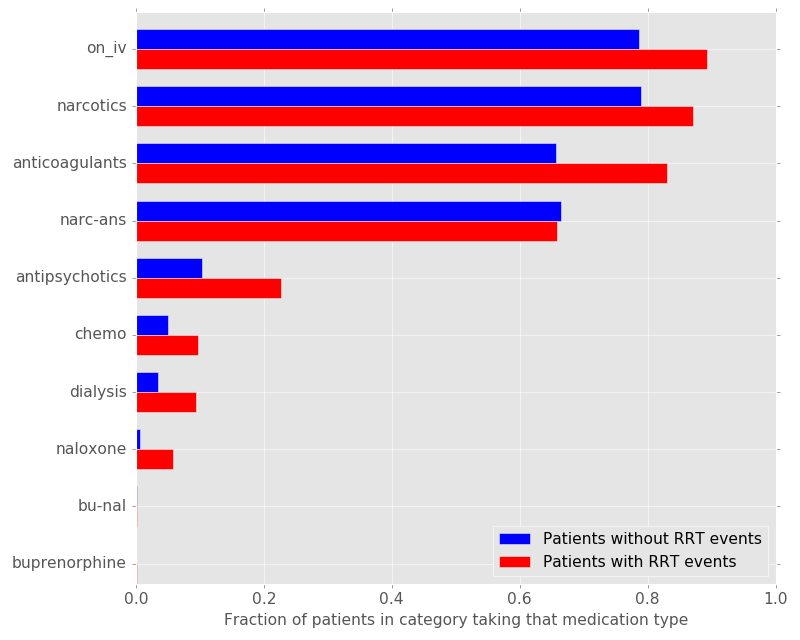

In [21]:
df = df.sort_values(by='fraction_rrt')
fig, ax = plt.subplots(figsize=(10,8))
bar_not_rrt = ax.barh(ind+width, df.fraction_notrrt, width, color = 'b')
bar_rrt = ax.barh(ind, df.fraction_rrt, width, color='r')
ax.set_yticks(ind+width)
ax.set_yticklabels((df.medication))
ax.set_xlim([0,1])
ax.tick_params(labelsize='14')
ax.set_xlabel('Fraction of patients in category taking that medication type', fontsize='14')
ax.legend(('Patients without RRT events', 'Patients with RRT events'), loc=4, fontsize='14')
plt.tight_layout()